<a href="https://colab.research.google.com/github/menon92/DL-Sneak-Peek/blob/master/%E0%A6%9F%E0%A7%87%E0%A6%A8%E0%A7%8D%E0%A6%B8%E0%A6%B0%E0%A6%AB%E0%A7%8D%E0%A6%B2%E0%A7%8B_%E0%A7%A8_%E0%A7%A6_%E0%A6%93_%E0%A6%95%E0%A7%87%E0%A6%B0%E0%A6%BE%E0%A6%B8_%E0%A6%AA%E0%A6%B0%E0%A6%BF%E0%A6%9A%E0%A6%BF%E0%A6%A4%E0%A6%BF_%E0%A6%AA%E0%A6%B0%E0%A7%8D%E0%A6%AC_%E0%A7%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ইমেজ ডাটা - প্রথম পর্ব

এখানে আমরা দেখব ডিপলার্নিং মডেল ট্রেনিং করার আগে ডাটা লোডিং পাইপলাইন কিভাবে করা হয় । এইজন্য ডাটাসেট হিসাবে ব্যাবহার করব 
<a herf="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"> flower photos</a>। এটা 218 MB সাইজের একটা ডাটাসেট। এই ডাটাসেট ব্যাবহার করে আমরা নিচের বিষয়গুলো কভার করার চেষ্টা করব । 

* `tf.keras.preprocessing.image.ImageDataGenerator` দিয়ে কিভাবে ইমেজ ডাটা লোড করা যায় । 
* `tf.data` দিয়ে কিভাবে ইমেজ ডাটা লোড করা যায় । 
* উপরের দুইটার কোনটাতে কি সুবিধা পাওয়া যাবে । 
* কোনটাতে কেমন সময় লাবে । 

### প্রয়োজনীয় প্যাকেজ ইম্পোট করে নেই 

In [0]:
try:
  # %tensorflow_version এই কমান্ড কেবলমাত্র colab এ কাজ করে লোকাল নোটবুকে কাজ করবে না । 
  # এই জন্য try except ব্যাবহার করা হয়েছে । 
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [17]:
# টেন্সফ্লো ভার্সন চেক করে নিন 
tf.__version__

'2.2.0-rc2'

### ডাটাসেট ডাউনলোড 

ডাটাসেট ডাউনলোড করার জন্য আমরা `tf.keras.utils.get_file` এই ফাংশন ব্যাবহার করব । এখানে আমরা ডাটাসেট url এবং কি নামের (`fname='flower_photos'`) ফোল্ডারে ডাউনলোড হয়ে জমা হবে সেটা বলে দিচ্ছি । এবং `flower_photos.tgz` যেহেতু একটা জিপ ফাইল তাই এটাকে আনজিপ করার জন্য আমরা `untar=True` দিয়ে দিব ।

In [18]:
import pathlib

DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

data_dir = tf.keras.utils.get_file(origin=DATASET_URL, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
print('Dataset directory:', data_dir)

Dataset directory: /root/.keras/datasets/flower_photos


In [19]:
!sudo apt install -qq tree
!tree -L 1 /root/.keras/datasets/flower_photos

tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
/root/.keras/datasets/flower_photos
├── daisy
├── dandelion
├── LICENSE.txt
├── roses
├── sunflowers
└── tulips

5 directories, 1 file


আমরা দেখতে পাচ্ছি যে ৫ টা আলাদা আলাদা ফুলের ফোল্ডার আছে এবং একটা টেক্সট ফাইল আছে । 

In [20]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

আমরা দেখতে পাচ্ছি যে সব মিলে ৩৬৭০ টা ফুলের ছবি আছে । এখন আমরা দেখব যে কোন ফুল কয়টা করে আছে । 

In [21]:
FLOWERS = ['daisy', 'dandelion', 'roses','sunflowers','tulips']
for flower in FLOWERS:
    total_flower = len(list(data_dir.glob(flower + "/*.jpg")))
    print("`{:10s}` folder contain {} flower images".format(flower, total_flower))

`daisy     ` folder contain 633 flower images
`dandelion ` folder contain 898 flower images
`roses     ` folder contain 641 flower images
`sunflowers` folder contain 699 flower images
`tulips    ` folder contain 799 flower images


আমরা কিছু ৩ টা টিউলিপ ফুল প্লট করে দেখি । আমরা প্রত্যেকটা ফুলের ছবির সাথে তাদের সাইজ প্রিন্ট করেছি । এবং আমরা দেখতে পাচ্ছি যে এক একটা ছবির সাইজ এক এক রকম । আমাদের মডেলে ডটা ফিট করার আগে অবশ্যই সব ছবিকে একটা ফিক্স সাইজে নিয়ে আসতে হবে । 

image size (240, 240)


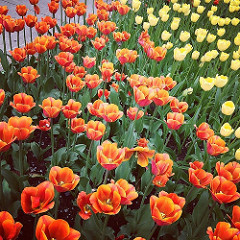

image size (500, 241)


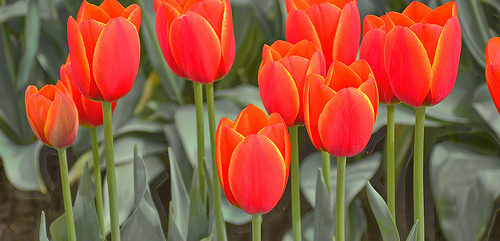

image size (320, 240)


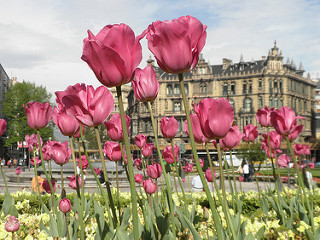

In [22]:
roses = list(data_dir.glob('tulips/*'))

for image_path in roses[:3]:
    image = Image.open(str(image_path))
    print('image size', image.size)
    display.display(image)

২য় পর্বে আমরা দেখব কিভাবে `tf.data` দিয়ে ইমেজ লোড করা যায় 